In [36]:
import sys
import time
import pickle
import numpy as np
import pandas as pd
from functools import partial, update_wrapper

from multiprocessing import Pool

from skimage import io
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss

import keras 
from keras import objectives
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from scripts.image import load_image

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

### Movie genre multi-class classifier
Trains convolution neural netowrk (based on inception V3 pre-trained network) to predict a movie genre based on the poster image. A movie can be assiciated with one genre.

In [2]:
# wraps a function and preserves some atributes (required by Keras)
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

In [3]:
# cross entropy that takes into account class weight
def weighted_crossentropy(y_true, y_pred, weight):
    # clip 0s or 1s
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    # binary cross entropy
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.dot(out, K.transpose(weight)) # weighted

In [4]:
img_rows, img_cols = 224, 224

In [5]:
# load images into memory
with open('data/tmdb_info.pickle', 'rb') as handle:
    tmdb_dict =  pickle.load(handle)
with Pool(6) as p:
    rs = p.map_async(load_image, list(tmdb_dict.keys()))
    p.close()
    while (True):
        if (rs.ready()): break
        remaining = rs._number_left
        print("Waiting for", remaining, "tasks to complete...")
        time.sleep(10)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 22 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 14 tasks to complete...
Waiting for 10 tasks to complete...
Waiting for 5 tasks to complete...
Waiting for 1 tasks to complete...


In [6]:
# extract labes for the loaded images
labels = []
features = []
for r in rs.get():
    if(r[1] is not None):
        movie_genres = tmdb_dict[r[0]].__dict__['genres']
        if(movie_genres is None or len(movie_genres) == 0):
            continue
        labels.append([g['name'] for g in movie_genres])
        features.append(r[1])
features = np.asarray(features)
rs = None
tmdb_dict = None

In [7]:
# create the labels vector
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
output_size = y.shape[1]
print('label matrix shape:', y.shape)

label matrix shape: (58825, 20)


### Class weights  
Most frequent class will have weight 1.0, other classes will receive bigger weights reverse proportional to their relative frequencies.

In [8]:
# class weights, most frequent class will have weight 1.0
# other classes will receive bigger weigths reverse proportional to their relative frequencies
class_freq = y.sum(axis = 0)
class_weight = class_freq.max()/class_freq
class_weight

array([  3.43354177,   6.49136102,   5.27593003,   1.43937357,
         5.53645295,   2.52923113,   1.        ,   6.09940188,
         9.90518039,  11.02161606,  15.28551035,   4.28043174,
         4.82645932,  10.5805336 ,   3.52046687,   8.64903069,
        18.21003401,   3.73083624,  17.24235105,  15.88649852])

In [9]:
# put aside 10% of data for testing
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state = 540,  stratify = y)
print('Train label matrix shape:', y_train.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (52942, 20)
Train predictor matrix shape: (52942, 224, 224, 3)
Test label matrix shape: (5883, 20)
Test predictor matrix shape: (5883, 224, 224, 3)


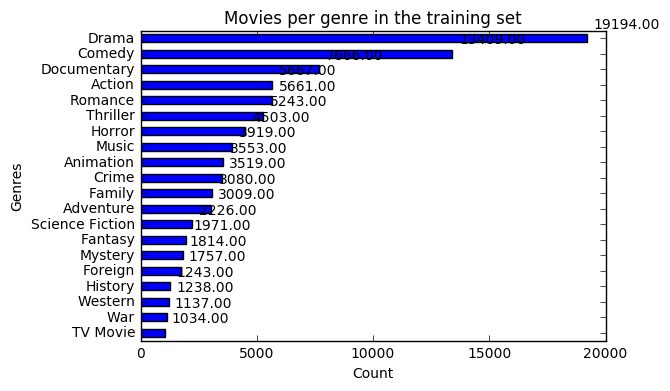

In [11]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

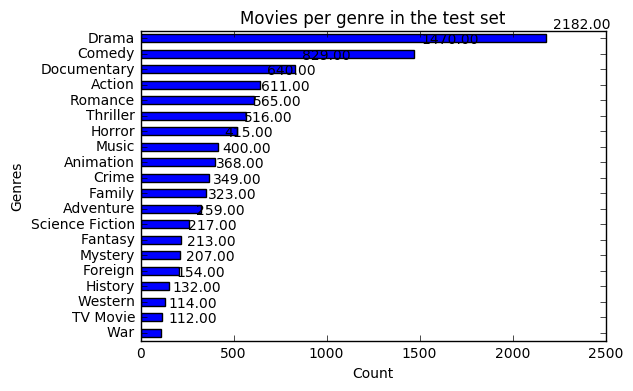

In [12]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

In [13]:
# create model absed on inception V3 CNN
def create_v3():
    input_shape = (224, 224, 3)

    base_model = InceptionV3(
        input_shape = input_shape, 
        weights='imagenet', 
        include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(output_size, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    return model

In [14]:
model = create_v3()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 111, 111, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 111, 111, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [15]:
earlyStopping = EarlyStopping(
    monitor='val_acc', patience = 5, min_delta = 0.01, verbose = 0, mode = 'max')

In [20]:
# custom loss
loss = wrapped_partial(weighted_crossentropy, weight = K.variable(np.array([class_weight])))

In [21]:
# train the output layer
model.compile(optimizer = 'rmsprop', loss = loss, metrics=['accuracy'])

In [22]:
history = model.fit(
    X_train, 
    y_train, 
    class_weight = class_weight,
    batch_size = 256, 
    epochs = 5, 
    verbose = 1,
    validation_split = 0.2, # 20% reserved for held-out validation data
    callbacks = [earlyStopping]
)

Train on 42353 samples, validate on 10589 samples
Epoch 1/5
42353/42353 [==============================] - 458s - loss: 32.5773 - acc: 0.2277 - val_loss: 30.4498 - val_acc: 0.2857
Epoch 2/5
42353/42353 [==============================] - 448s - loss: 28.0001 - acc: 0.2724 - val_loss: 35.7838 - val_acc: 0.3013
Epoch 3/5
42353/42353 [==============================] - 447s - loss: 26.9957 - acc: 0.2808 - val_loss: 27.6142 - val_acc: 0.2912
Epoch 4/5
42353/42353 [==============================] - 448s - loss: 26.3733 - acc: 0.2948 - val_loss: 32.7479 - val_acc: 0.2920
Epoch 5/5
42353/42353 [==============================] - 449s - loss: 25.9260 - acc: 0.2996 - val_loss: 29.8142 - val_acc: 0.3215


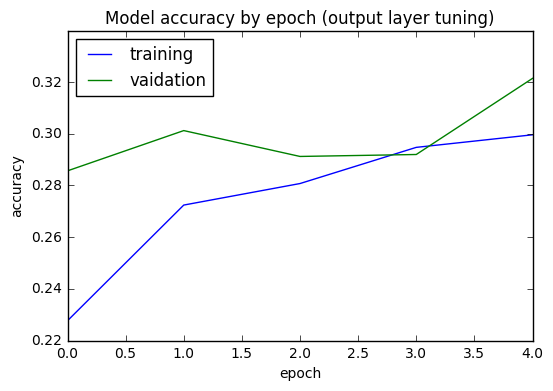

In [23]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.title('Model accuracy by epoch (output layer tuning)')

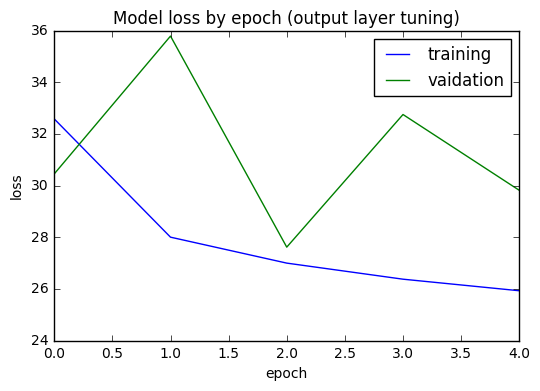

In [24]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title('Model loss by epoch (output layer tuning)')

In [25]:
model.save('models/cnn_v3_20.h5')

In [26]:
# fine tune the top 2 inception blocks
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

In [27]:
model.compile(
    optimizer=SGD(lr = 0.0001, momentum=0.9), 
    loss = loss, 
    metrics=['accuracy'])

In [28]:
history = model.fit(
    X_train, 
    y_train, 
    class_weight = class_weight,
    batch_size = 256,
    epochs = 50, 
    verbose = 1,
    validation_split = 0.2, # 20% reserved for held-out validation data,
    callbacks = [earlyStopping]
)

Train on 42353 samples, validate on 10589 samples
Epoch 1/50
42353/42353 [==============================] - 621s - loss: 24.4377 - acc: 0.3196 - val_loss: 27.2552 - val_acc: 0.3432
Epoch 2/50
42353/42353 [==============================] - 613s - loss: 22.8796 - acc: 0.3382 - val_loss: 25.6669 - val_acc: 0.3527
Epoch 3/50
42353/42353 [==============================] - 613s - loss: 21.5137 - acc: 0.3583 - val_loss: 24.4003 - val_acc: 0.3642
Epoch 4/50
42353/42353 [==============================] - 612s - loss: 20.2050 - acc: 0.3698 - val_loss: 23.3255 - val_acc: 0.3710
Epoch 5/50
42353/42353 [==============================] - 613s - loss: 18.9491 - acc: 0.3877 - val_loss: 22.8134 - val_acc: 0.3754
Epoch 6/50
42353/42353 [==============================] - 613s - loss: 17.6968 - acc: 0.3974 - val_loss: 22.1424 - val_acc: 0.3770
Epoch 7/50
42353/42353 [==============================] - 613s - loss: 16.4114 - acc: 0.4071 - val_loss: 21.7147 - val_acc: 0.3812
Epoch 8/50
42353/42353 [=========

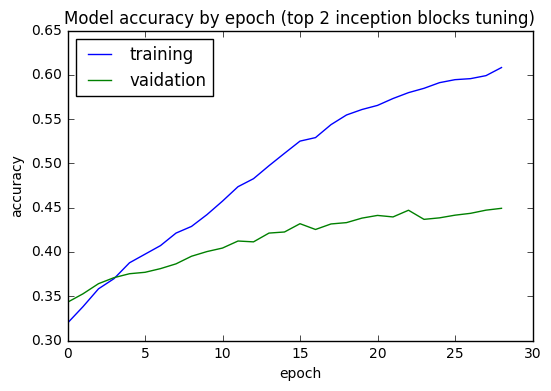

In [29]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.title('Model accuracy by epoch (top 2 inception blocks tuning)')

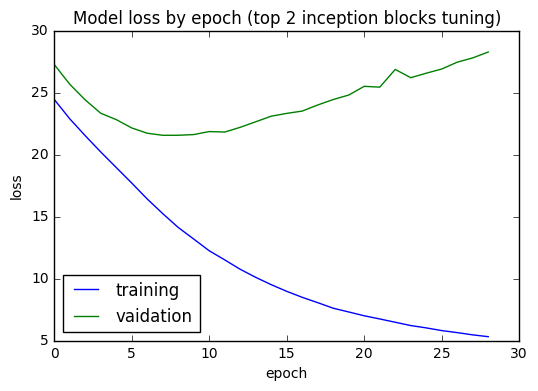

In [30]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title('Model loss by epoch (top 2 inception blocks tuning)')

In [31]:
model.save('models/cnn_v3_20.h5')

In [32]:
y_train_pred_proba = model.predict(X_train)
y_train_pred = np.zeros(y_train_pred_proba.shape)
y_train_pred[y_train_pred_proba > 0.5] = 1

In [33]:
y_test_pred_proba = model.predict(X_test)
y_test_pred = np.zeros(y_test_pred_proba.shape)
y_test_pred[y_test_pred_proba > 0.5] = 1

In [37]:
train_report = classification_report(y_train, y_train_pred, target_names=mlb.classes_, digits=3)
test_report =  classification_report(y_test, y_test_pred, target_names=mlb.classes_, digits=3)

print ('hamming loss: %.3f' % hamming_loss(y_test, y_test_pred))
print ('Train performance: ')
print (train_report)
print ('Test performance: ')
print (test_report)

hamming loss: 0.067
Train performance: 
                 precision    recall  f1-score   support

         Action      0.790     0.744     0.766      5667
      Adventure      0.905     0.805     0.852      3009
      Animation      0.927     0.910     0.918      3553
         Comedy      0.734     0.667     0.699     13409
          Crime      0.881     0.851     0.866      3519
    Documentary      0.862     0.863     0.862      7666
          Drama      0.702     0.683     0.692     19194
         Family      0.924     0.880     0.902      3080
        Fantasy      0.956     0.876     0.914      1971
        Foreign      0.945     0.863     0.902      1757
        History      0.979     0.877     0.925      1243
         Horror      0.865     0.818     0.841      4503
          Music      0.934     0.866     0.899      3919
        Mystery      0.956     0.856     0.903      1814
        Romance      0.868     0.740     0.799      5661
Science Fiction      0.949     0.857     0.901 

In [38]:
# save test classification report
with open('models/cnn_v3_20_report.pickle', 'wb') as handle:
    pickle.dump(test_report, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [39]:
# save test data so we can evaluate performance again
with open('models/cnn_v3_20_test.pickle', 'wb') as handle:
    pickle.dump((X_test, y_test), handle, protocol = pickle.HIGHEST_PROTOCOL)